Initiation

In [1]:
import numpy                   as np
import pandas                  as pd
import matplotlib.pyplot       as plt
import seaborn                 as sns
import warnings
from   sklearn.preprocessing   import StandardScaler, PolynomialFeatures, QuantileTransformer, OneHotEncoder
from   sklearn.compose         import ColumnTransformer, TransformedTargetRegressor
from   sklearn.linear_model    import LinearRegression, Ridge, Lasso
from   sklearn.pipeline        import make_pipeline
from   sklearn.model_selection import learning_curve, train_test_split,LeaveOneOut, cross_val_score, KFold,GridSearchCV
from   sklearn.metrics         import mean_squared_error, r2_score
from   sklearn.svm             import SVR
warnings.filterwarnings('ignore')

In [2]:
dataset = pd.read_csv('Insurance_dataset.csv')
dataset.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


Data Insights : 
We will use the data to learn more about the data with the help of visualisation.

Text(0.5, 0, 'Age')

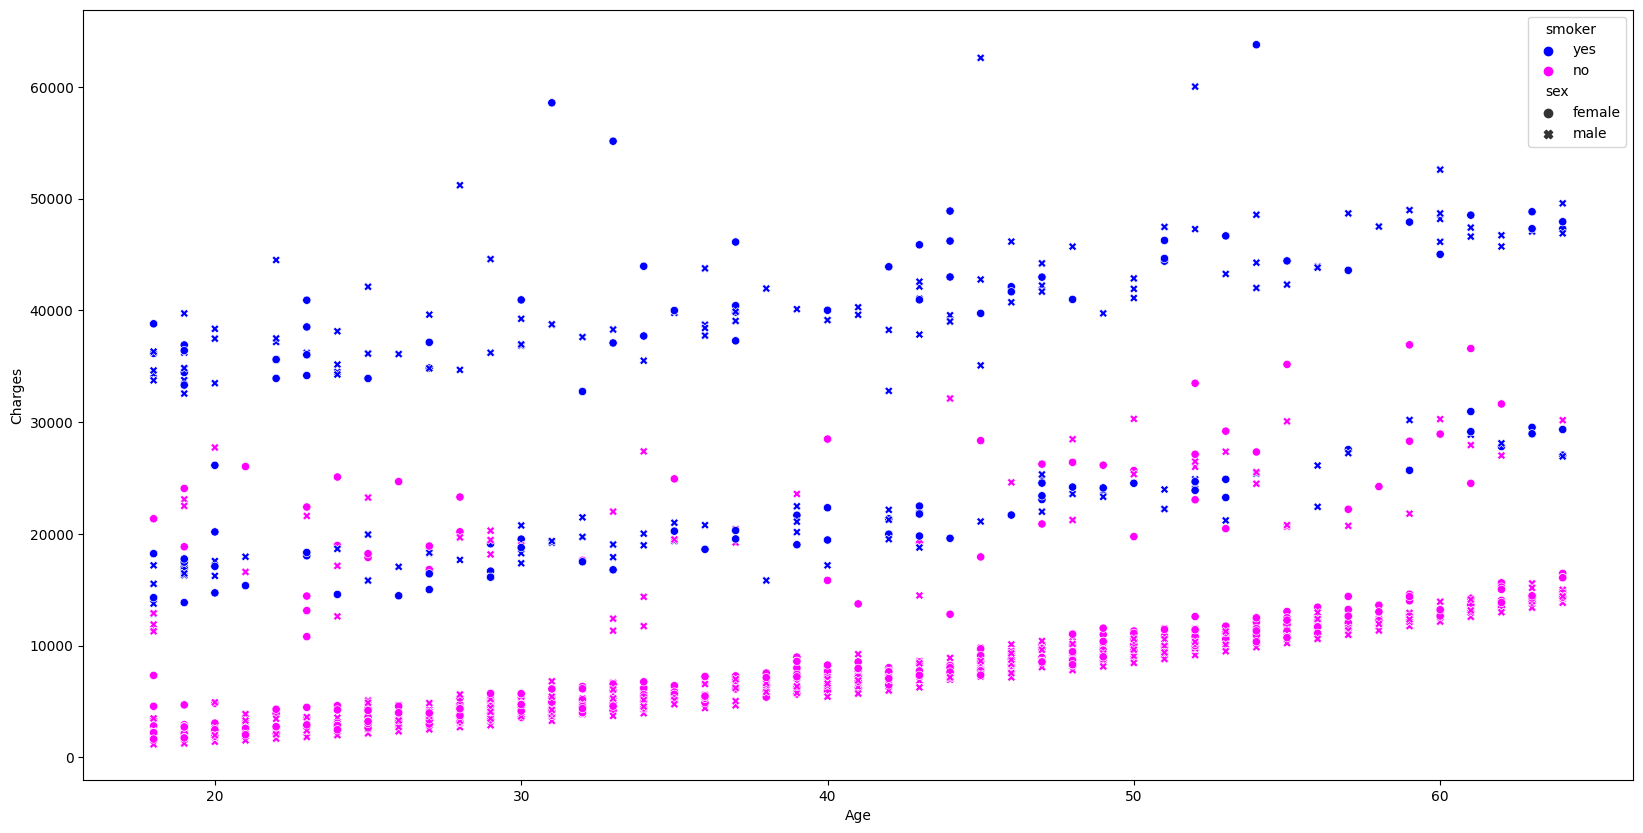

In [5]:
plt.figure(figsize=(20, 10))
sns.scatterplot(x = dataset['age'], y = dataset['charges'], color = 'blue', hue = dataset['smoker'], palette= ['blue','magenta'],style=dataset['sex'])
plt.ylabel('Charges')
plt.xlabel('Age')

As we can see here clearly that not only the charges increase as a person grows older but also smokers generally then to have higher charges for health insaurance. We can also observe that sex has no effect on the charges of health insaurance neither with age or being a smoker or not.

Text(0.5, 0, 'BMI')

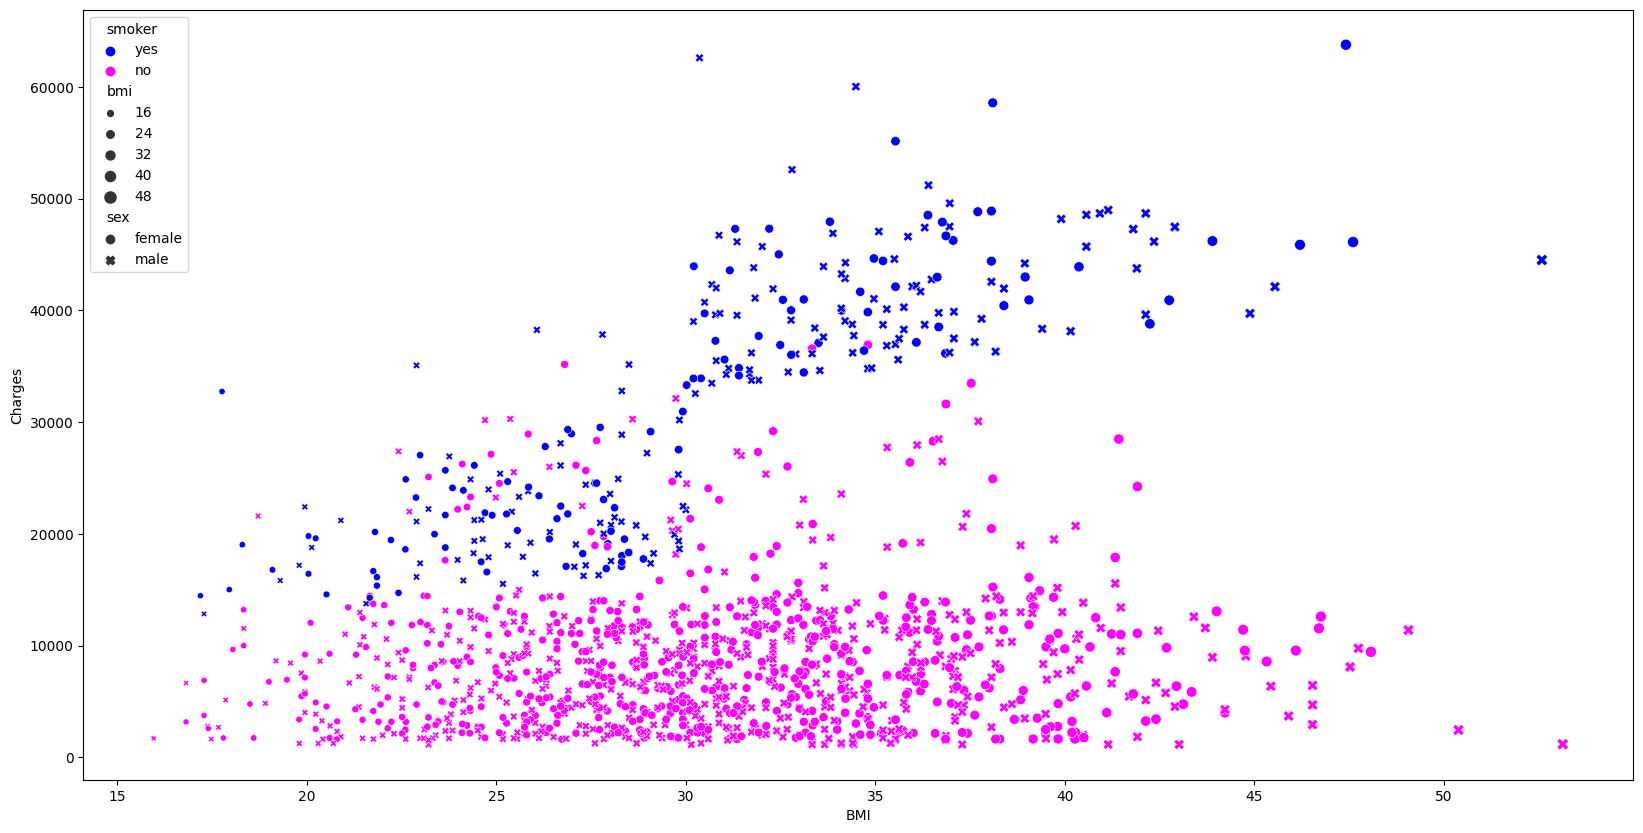

In [7]:
plt.figure(figsize=(20, 10))
sns.scatterplot(x = dataset['bmi'], y = dataset['charges'], color = 'blue', size = dataset['bmi'],hue = dataset['smoker'], palette = ['blue','magenta'], style = dataset['sex'])
plt.ylabel('Charges')
plt.xlabel('BMI')

Again in this graph we can observe that sex doesn't have any effect on the health insaurance charges. We can also see that for people with high bmi and who smoke, the charges increase exponentially with their bmi.

Text(0.5, 0, 'Age')

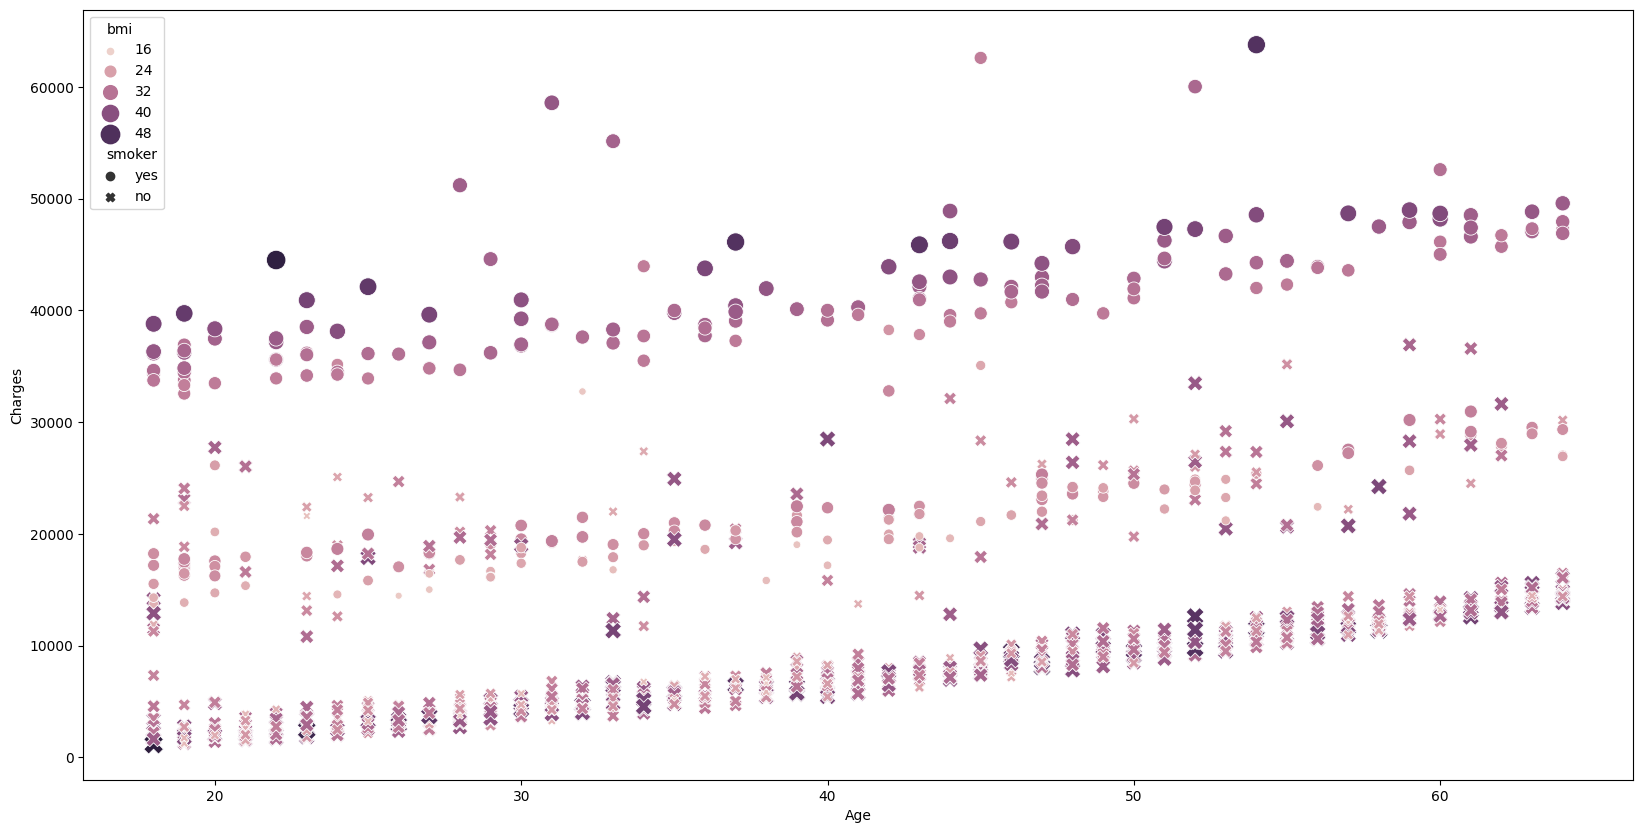

In [8]:
plt.figure(figsize=(20, 10))
sns.scatterplot(x = dataset['age'], y = dataset['charges'], hue = dataset['bmi'],size = dataset['bmi'], style=dataset['smoker'], sizes = (20,200))
plt.ylabel('Charges')
plt.xlabel('Age')

Here we can see that even if non smokers have high bmi their charges much lower than those of smokers. Also we can see that for smokers with higher bmi's have more charges than the ones with lower bmi's.

Text(0.5, 0, 'children')

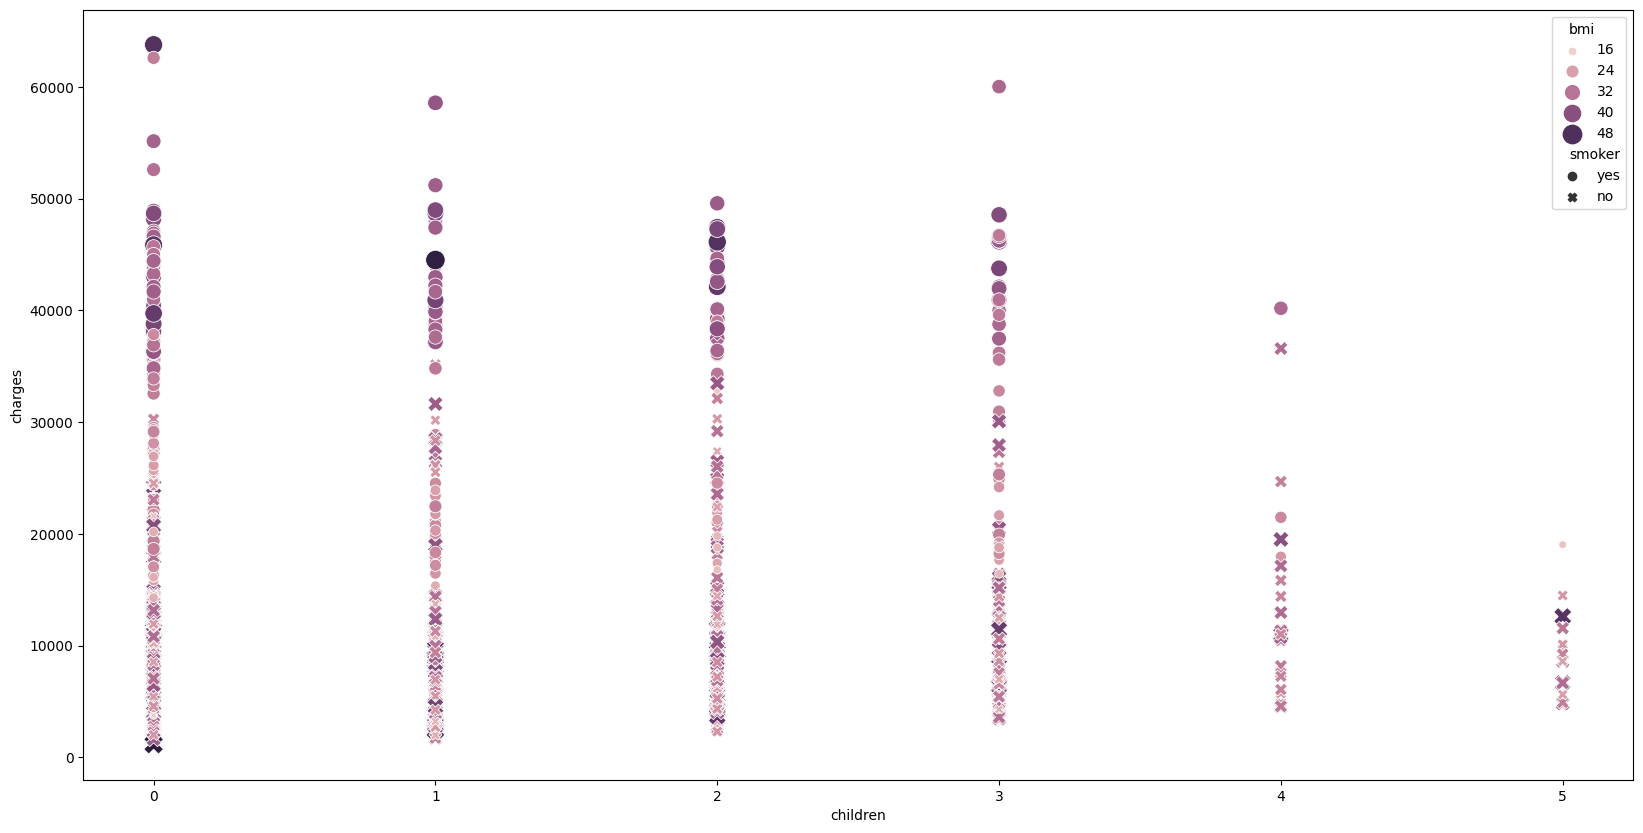

In [9]:
plt.figure(figsize=(20, 10))
sns.scatterplot(x = dataset['children'], y = dataset['charges'], hue = dataset['bmi'],size = dataset['bmi'], style=dataset['smoker'], sizes = (20,200))
plt.ylabel('charges')
plt.xlabel('children')

Text(0.5, 0, 'region')

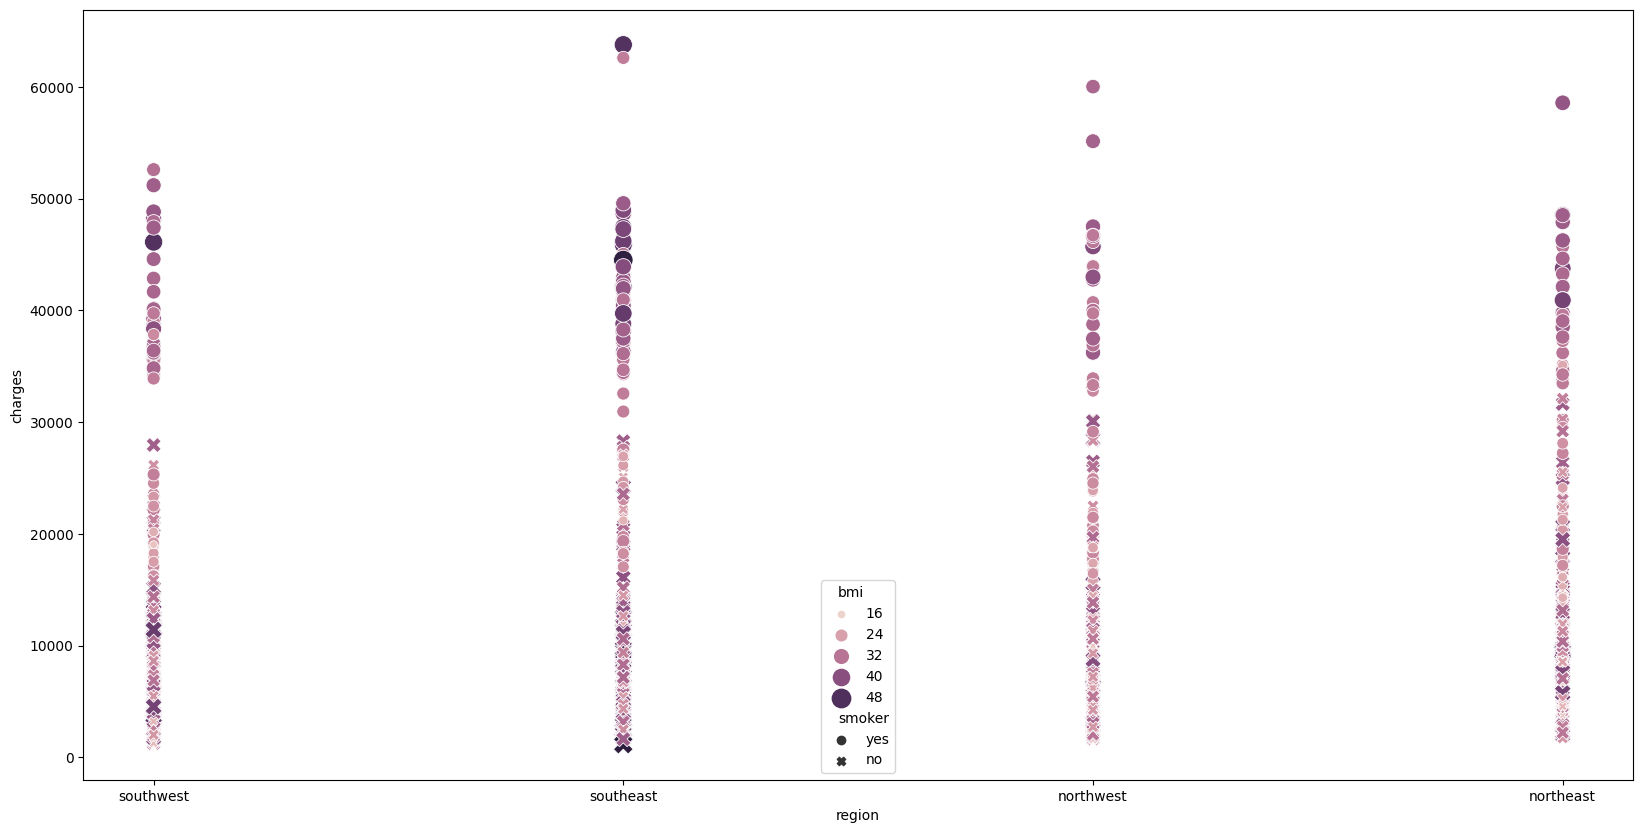

In [10]:
plt.figure(figsize=(20, 10))
sns.scatterplot(x = dataset['region'], y = dataset['charges'], hue = dataset['bmi'],size = dataset['bmi'], style=dataset['smoker'], sizes = (20,200))
plt.ylabel('charges')
plt.xlabel('region')

Number of children has very little effect on the charges of the health insaurance, it is difficult to observe any significant difference because of the number of children with the help of the graph. Same is true for region.

So from the insights we can say that the following feaures are of primary importance :

1 Age
2 BMI
3 Smoker

Develop preprocesses, Models and Evaluation

We will develop various preprocessing pipelines and compare them in order to select the best one. After that we develop various models and compare them and select the best one out of them.

In [11]:
#Divide the data frame into Dependent(y) and Independent(X) variable data frames.
X = dataset.drop('charges', axis = 1)
y = dataset.charges

In [12]:
#Classify the features (independent variables into Categorical and Numerical classes)
#Only the categorical columns would be taken into account for preprocessing. 
categorical_col = ["sex","smoker","region"]
numerical_col   = [col for col in X.columns if col not in categorical_col]

Building the pipeline : Different pipelines are developed for preprocessing and modeling methods. Each has its own variants but all perform one hot encoder and drop the first categorical value to avoid colinearity.

In [13]:
#encoding categorical values.

encoding_preprocess = ColumnTransformer(transformers = [("encoding",OneHotEncoder(drop='first'), categorical_col)],
                                        remainder= 'passthrough')

#----------------------------------------------------------------------------
#simple linear model process

linear_regression = make_pipeline(encoding_preprocess,
                                  LinearRegression())

#------------------------------------------------------------------------------
#This process indicates interactions are restricted between only numerical features, leaving relationships within binary and numerical out of the picture.

polynomial_preprocess_1 = make_pipeline(ColumnTransformer(transformers =[("encoding", OneHotEncoder(drop='first'), categorical_col),
                                                                         ('polynomial_scale', make_pipeline(PolynomialFeatures(degree=2, interaction_only= True), StandardScaler()), numerical_col)],
                                                          remainder= 'passthrough'))

polynomial_regression_1 = make_pipeline(polynomial_preprocess_1,
                                        LinearRegression())

#-------------------------------------------------------------------------
#The quadratic regression would now make interactions between all the variables including dummy with numerical. No scaling is performed right now. 
#It applies the preprocess, polynomial feature and linear regression.

polynomial_regression_2 = make_pipeline(encoding_preprocess,
                                        PolynomialFeatures(degree=2),
                                        StandardScaler(),
                                        LinearRegression())

Dividing the train-test set : 
The division of our training and test set is developed to avoid any leakage of data from test to training and fitting

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state= 42)
X_train.head()

,age,sex,bmi,children,smoker,region
693,24,male,23.655,0,no,northwest
1297,28,female,26.510,2,no,southeast
634,51,male,39.700,1,no,southwest
1022,47,male,36.080,1,yes,southeast
178,46,female,28.900,2,no,southwest


Compare three type of regression preprocessing linear models by KFold and see which is the best :
Bases on the three models we fit them to evaluate their MSE and standard deviation with KFold. At the end we want to choose the approximate best to apply some regularization.

In [21]:
def Score_by_KFold(model, num_folds):
    score = cross_val_score(estimator = model, X = X, y = y, cv = KFold(num_folds, shuffle= True), scoring= "neg_mean_squared_error")
    return round(-np.average(score),2), round(np.std(score),0)

In [22]:
MSE1, std1 = Score_by_KFold(linear_regression,20)
MSE2, std2 = Score_by_KFold(polynomial_regression_1,20)
MSE3, std3 = Score_by_KFold(polynomial_regression_2,20)
print("Linear Regression MSE:", MSE1, " & Standard Deviation: ",std1)
print("Polynomial Regression MSE:", MSE2, "& Standard Deviation: ",std2)
print("Polynomial Regression MSE:", MSE3, "& Standard Deviation: ",std3)

Linear Regression MSE: 37097558.23  & Standard Deviation:  8615227.0
Polynomial Regression MSE: 37220173.72 & Standard Deviation:  8710253.0
Polynomial Regression MSE: 26811294.38 & Standard Deviation:  10071586.0


We write a function to return the model's Mean Squared Error and Mean of the same

In [23]:
def display_mse (model,x,y):
  cv_scores = -cross_val_score(model,x,y,scoring='neg_mean_squared_error',cv=10)
  return cv_scores, cv_scores.mean()

Best degree 2 with MSE 24802520.76


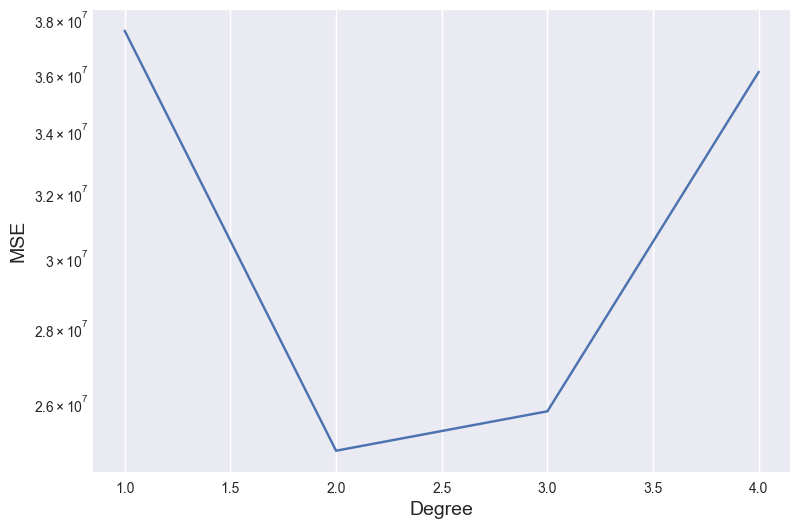

In [24]:
mses = []
min_mse = 1000000000
degrees = np.arange(1,5)


for deg in degrees: 
    poly_features = make_pipeline(encoding_preprocess,
                                  PolynomialFeatures(degree = deg))
    x_poly = poly_features.fit_transform(X_train)
    poly_mse, poly_mean = display_mse (LinearRegression(), x_poly, y_train)
    mses.append(poly_mean)

    if min_mse > poly_mean:
        min_mse = poly_mean
        min_deg = deg


print('Best degree {} with MSE {}'.format(min_deg, round(min_mse,2)))

plt.figure(figsize = (9,6))
plt.style.use('seaborn')
plt.plot(degrees, mses)
plt.yscale('log')
plt.xlabel('Degree',fontsize = 14)
plt.ylabel('MSE',fontsize = 14)
plt.show()

This graph shows that the polynomial regression with degree 2 gives the least mean_squared_error, Thus being the best model for our use case.

After performing a KFOLD on the training set the polynomial regression type 2 shows a better performance when taking into account MSE and standard deviation.

Feature Selection : We perform Backward stepwise feature selection as we don't have that many features to start with. It will only be done with a degree of 2 because of the previous evaluations.

In [26]:
def get_model(current_features):
    categorical_features1 = list()
    for f in current_features:
        if f in ['sex','smoker','region']:
            categorical_features1.append(f)
    numerical_features1 = [col for col in current_features if col not in ['sex','smoker','region']]

    return make_pipeline(
                ColumnTransformer(transformers=[
                ('categorical',OneHotEncoder(),categorical_features1),
                ('numerical',
                make_pipeline(PolynomialFeatures(degree=2),StandardScaler()),
                numerical_features1)]),
                LinearRegression())

In [27]:
class Solution:
    features = list()
    mse = float('Inf')

    def __init__(self,y,features=None,mse = None):
        if features and mse:
            self.feature = features
            self.mse = mse
        else:
            pred = [y.mean()]*len(y)
            self.features = list()
            self.mse = mean_squared_error(y,pred)

    def update(self,features, mse):
        if mse < self.mse:
            self.features = features
            self.mse = mse
            return True
        return False

current_features = list(categorical_col)
best = Solution(
    y=y,
    features=current_features,
    mse = -np.average(
        cross_val_score(
            estimator=get_model(current_features),
            X=X,y=y, cv = KFold(n_splits=10,shuffle=True,random_state=3),
            scoring='neg_mean_squared_error'
        )
    )
)

while len(current_features) > 0:
    removed_feature = None

    for f in current_features:
        new_features = [f1 for f1 in current_features if f1 != f]
        mses = cross_val_score(
            estimator=get_model(new_features),
            X=X[new_features],y=y,cv = KFold(n_splits=10,shuffle=True,random_state=3),
            scoring='neg_mean_squared_error'
        )
        mse = -np.average(mses)

        if best.update(new_features,mse):
            removed_feature = f
    
    if removed_feature:
        current_features.remove(removed_feature)
    else:
        break

In [28]:
print('Selected features: ', end='')
print(', '.join(best.feature))

Selected features: smoker


Hyperparameter Tuning development :
Develop hyperparameter tuning with best preprocessing type. The purpose is to reduce effect of higher dimensionality and avoid overfitting so the model can adapt better to new datasets.

From the feature selection we can infer that we get the best results using only three features and since we want to stay with our relevant generated features and reduce the others coefficients to zero we will apply the lasso regularisation in order to avoid overfiting of the model.

Since Lasso uses MSE as part of its loss function to make consistant comparisons of accuracy we have used MSE as well for all our evaluations as a metric. Also in company we have kept our score just to see the correlations performance.

In [29]:
poly_Lasso = make_pipeline(encoding_preprocess,
                                PolynomialFeatures(degree=2),
                                StandardScaler(),
    GridSearchCV(
        estimator=Lasso(),
        param_grid={
            'alpha': np.logspace(-4, 1.5, 100)
        },
        cv=10,
        scoring='neg_mean_squared_error'
    )
)

poly_Lasso.fit(X_train, y_train)
print(poly_Lasso[-1].best_params_)
print('MSE: ',round(-poly_Lasso[-1].best_score_))
print('Standard Error: ',round(np.mean((poly_Lasso[-1].cv_results_['std_test_score'])),2))

{'alpha': 16.68100537200059}
MSE:  24149521
Standard Error:  5753555.23


In [30]:
z = (poly_Lasso[-1].best_estimator_.coef_)
print("Amount of coefficients different than 0 in Lasso are: ",len(list(i for i in z if i != 0)),"/",len(z))

Amount of coefficients different than 0 in Lasso are:  26 / 45


Prediction : We predict with the help of Lasso regularised polynomial function on our test set and got the most accurate result for us.

In [32]:
y_pred_poly = poly_Lasso.predict(X_test)
y_pred_poly
pd.DataFrame([[int(mean_squared_error(y_pred_poly,y_test)), r2_score(y_test,y_pred_poly).round(3)]], columns=['MSE', 'Score'])

,MSE,Score
0,21962084,0.854


We will begin to create our residuals table to highlight the prediction power of our model taking 0 as the base.

In [33]:
Comparison_poly = pd.DataFrame

Comparison_poly = pd.concat(
    [pd.DataFrame(y_test).rename(columns = {'charges': 'Real charges'}).reset_index(drop=True).round(2),
    pd.DataFrame(y_pred_poly, columns = ['Predicted Charges'])], axis = 1
    ).round(2)

Comparison_poly['Residuals'] = Comparison_poly['Real charges'] - Comparison_poly['Predicted Charges']

Comparison_poly.head(5)

,Real charges,Predicted Charges,Residuals
0,9095.07,10929.48,-1834.41
1,5272.18,6278.74,-1006.56
2,29330.98,33713.94,-4382.96
3,9301.89,10719.31,-1417.42
4,33750.29,29206.53,4543.76


Text(0, 0.5, 'Difference of model')

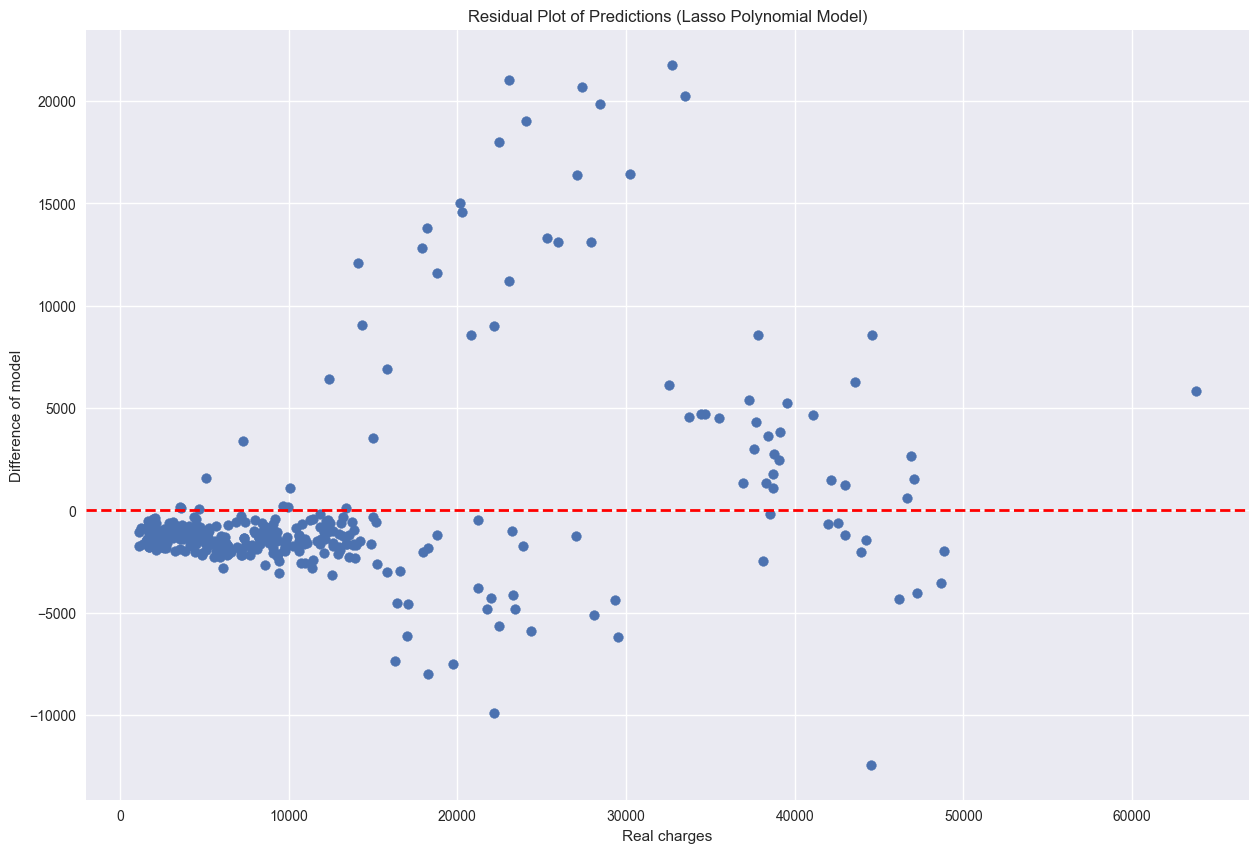

In [34]:
plt.figure(figsize=(15, 10))
plt.scatter(Comparison_poly['Real charges'], Comparison_poly['Residuals'])
plt.axhline(y=0,linewidth=2, color='red', linestyle = 'dashed')
plt.title("Residual Plot of Predictions (Lasso Polynomial Model)")
plt.xlabel('Real charges')
plt.ylabel('Difference of model')

Trying new approaches to improve the model.

Evaluating improvement by using Transformed Target Regressor and changing the distribution of the label for training and then transform it back at prediction

In [35]:
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import QuantileTransformer

The distribution of our labels looks strong skewed to the right. To be conservative we will use the rule that if our data is out of the range of skewness(-1,1) it is not normal, although there are cases where higher values may be taken into account. In this case if we want to detect outliers (to decide if they are relevant or affecting our model) we cannot use our standard 3 sigma method. It will need a transformation and then another backwards transformation to intepret the results of a prediction in charges amount. The function transformed target regressor can be useful.

It could be the case we ignore this procedure based on our models performance, or probably enhance it (if there are few outliers) by searching for them with a transformation of the column.

In [36]:
y_train
y_train_trans = np.log(y)

In [37]:
print('Skewness :', round(dataset['charges'].skew(),2))
print('Kurtosis :', round(dataset['charges'].kurtosis(),2))

Skewness : 1.52
Kurtosis : 1.61


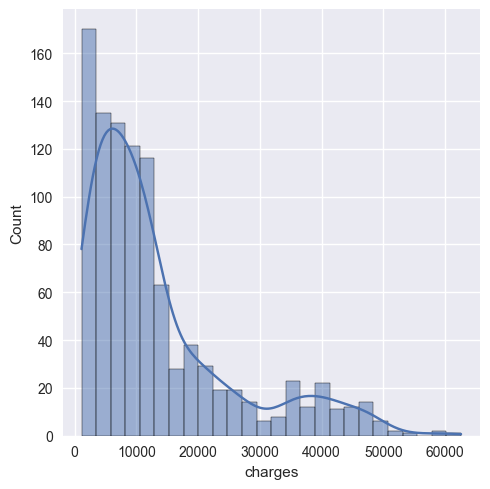

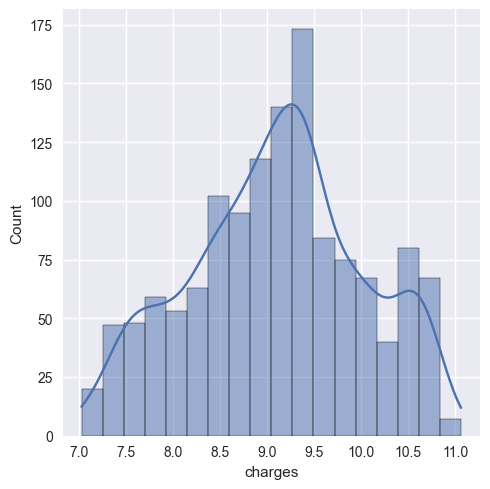

In [39]:
sns.displot(x=  y_train, kde=True)

sns.displot(x= y_train_trans, kde=True)

There are several functions we can use but we will show this with the natural logarithm for label transformation. We will first train our already picked model on the transformed label and then predict the value on the test set to see if any improvements are made.

In [40]:
#Example with log
poly_Lasso_with_targettransform = TransformedTargetRegressor(regressor =  poly_Lasso, func = np.log, inverse_func= np.exp)
poly_Lasso_with_targettransform.fit(X_train, y_train)

TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=Pipeline(steps=[('columntransformer',
                                                      ColumnTransformer(remainder='passthrough',
                                                                        transformers=[('encoding',
                                                                                       OneHotEncoder(drop='first'),
                                                                                       ['sex',
                                                                                        'smoker',
                                                                                        'region'])])),
                                                     ('polynomialfeatures',
                                                      PolynomialFeatures()),
                                                     ('standardscaler',
                 

In [41]:
y_pred_poly_tt = poly_Lasso_with_targettransform.predict(X_test)
y_pred_poly_tt
pd.DataFrame([[int(mean_squared_error(y_pred_poly_tt,y_test)), r2_score(y_test,y_pred_poly_tt).round(3)]], columns=['MSE', 'Score'])

,MSE,Score
0,24575506,0.837


There isn't a positive change in our results by predicting with the label normalized, so we will not take it into account on developing a new training method with it.

Trailing with other types of regression models (Random Forrest)

In [42]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

In [43]:
#Random Forest Grid Search

RF = make_pipeline(encoding_preprocess,
                                PolynomialFeatures(degree=2),
                                StandardScaler(),
    GridSearchCV(
        estimator=RandomForestRegressor(),
        param_grid = {'n_estimators': [10, 50, 100],  
            'max_features':['log2','sqrt']},
        cv=10,
        scoring='neg_mean_squared_error'
    )
)

RF.fit(X_train, y_train)
print(RF[-1].best_params_)
print('MSE: ',round(-RF[-1].best_score_))
print('Standard Error: ',round(np.mean((RF[-1].cv_results_['std_test_score'])),2))

{'max_features': 'sqrt', 'n_estimators': 100}
MSE:  22694650
Standard Error:  5722932.13


There is a good result with the MSE of the RFM, however is still slightly below the polynomial Lasso. The RFM works in a good way with a large amount of feautures (created by our polynomial interactions) and several observations.

Fitting the entire model

In [44]:
poly_Lasso.fit(X,y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encoding',
                                                  OneHotEncoder(drop='first'),
                                                  ['sex', 'smoker',
                                                   'region'])])),
                ('polynomialfeatures', PolynomialFeatures()),
                ('standardscaler', StandardScaler()),
                ('gridsearchcv',
                 GridSearchCV(cv=10, estimator=Lasso(),
                              param_grid={'alpha': array([1.00000000e-04, 1.13646367e-...
       1.66810054e+00, 1.89573565e+00, 2.15443469e+00, 2.44843675e+00,
       2.78255940e+00, 3.16227766e+00, 3.59381366e+00, 4.08423865e+00,
       4.64158883e+00, 5.27499706e+00, 5.99484250e+00, 6.81292069e+00,
       7.74263683e+00, 8.79922544e+00, 1.00000000e+01, 1.13646367e+01,
       1.29154967e+01, 1.46779927e+01, 1.6681005

Final Outcome : Once we decide our model (Polynomial Preprocessing Lasso with Grid Search), we train our model on the whole dataset to be ready to be deployed with new datasets having a larger sample.